In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from kret_studies import *
from kret_studies.notebook import *
from kret_studies.complex import *

logger = get_notebook_logger()

Loaded environment variables from /Users/Akseldkw/coding/kretsinger/.env.


INFO:datasets:JAX version 0.7.2 available.


In [3]:
from kret_studies.kret_torch import ClassificationNN

In [4]:
class ObesityPredNN(ClassificationNN):
    def set_model(self, input_dim: int, num_classes: int) -> None:
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )

In [5]:
run = start_wandb_run(ObesityPredNN.name(), project="obesity-risk-prediction")

wandb: Currently logged in as: akseldkw (akseldkw07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
KAGGLE_DIR = DATA_DIR / "kaggle"
OBESITY_DIR = KAGGLE_DIR / "playground-series-s4e2"

In [7]:
df = pd.read_csv(OBESITY_DIR / "train.csv")
df_test = pd.read_csv(OBESITY_DIR / "test.csv")

In [8]:
df.drop(columns=["id"], inplace=True)
df_test.drop(columns=["id"], inplace=True)

uks_pd.data_cleanup(df)
uks_pd.data_cleanup(df_test)

In [9]:
df.sample(4)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
16282,Male,18.000000,1.707787,75.000000,True,True,2.819934,3.000000,Sometimes,False,1.000000,False,0.917563,1.374650,Sometimes,Public_Transportation,Overweight_Level_I
3980,Male,18.951144,1.793315,89.429199,True,True,2.000000,2.977543,Sometimes,False,2.652616,False,2.000000,0.714701,Sometimes,Public_Transportation,Overweight_Level_I
13964,Female,19.529746,1.667404,49.932199,True,True,3.000000,3.000000,Sometimes,False,2.000000,False,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
16513,Male,20.825962,1.703688,80.000000,True,True,2.000000,3.000000,Sometimes,False,2.000000,False,0.000000,0.503896,no,Public_Transportation,Overweight_Level_II


In [10]:
df_test.sample(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
8985,Male,18.000000,1.770000,85.000000,True,True,2.000000,3.000000,Sometimes,False,2.000000,False,1.000000,1.000000,Sometimes,Public_Transportation
11880,Female,26.000000,1.624134,111.571076,True,True,3.000000,3.000000,Sometimes,False,2.619390,False,0.000000,0.258472,Sometimes,Public_Transportation
13062,Male,27.757187,1.848845,121.236915,True,True,2.680375,2.879541,Sometimes,False,1.555534,False,1.982379,0.000000,Sometimes,Public_Transportation


In [11]:
X, y = uks_pd.split_x_y(df, "NObeyesdad")

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
X_train.shape, X_val.shape

((16606, 16), (4152, 16))

In [15]:
model = ObesityPredNN(patience=200)

In [16]:
model.set_model(input_dim=X.shape[1], num_classes=y_val.cat.categories.size)
model.post_init()

[2025-11-14 13:44:13,746 | INFO | ObesityPredNN_v000 ] Loaded model weights and state from /Users/Akseldkw/coding/kretsinger/data/pytorch/ObesityPredNN_v000.
[2025-11-14 13:44:13,747 | INFO | ObesityPredNN_v000 ] Full State:
{'hparams': {'batchsize': 128,
             'gamma': 0.1,
             'improvement_tol': 0.0001,
             'lr': 0.001,
             'patience': 200,
             'stepsize': 7},
 'state': {'best_eval_accuracy': '87.57%',
           'best_eval_f1': '87.59%',
           'best_eval_loss': inf,
           'best_eval_r2': '-inf%',
           'epochs_trained': 603}}


In [ ]:
# model._log = False

In [18]:
model.train_model((X_train, y_train), (X_val, y_val), epochs=5_000, batch_size=320)

  4%|▍         | 204/5000 [01:12<24:39,  3.24it/s]

[2025-11-14 13:45:27,095 | WARNING | ObesityPredNN_v000 ] Early stopping activated: no improvement for 200 consecutive epochs.


  4%|▍         | 204/5000 [01:13<28:41,  2.79it/s]


In [19]:
y_true = np.random.randint(0, 5, size=100)
y_pred = np.random.randint(0, 5, size=100)

In [20]:
f1_score(y_true, y_pred, average="weighted")

0.25811938938254725

In [21]:
y_true_copy = y_true.copy()
f1_score(y_true_copy, y_true, average="weighted")

1.0

In [22]:
from sklearn.metrics import confusion_matrix

normalize = "true"  # or 'pred' or 'all' or None
cm = confusion_matrix(y_true, y_pred, normalize=normalize)

class_names = y.cat.categories.to_list()

fig, ax = uks_mpl.subplots(1, 1, 6, 6)
sns.heatmap(
    cm,
    ax=ax,
    annot=True,
    fmt=".2f" if normalize else "d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
title = "Confusion matrix" + (f" (normalize='{normalize}')" if normalize else "")
ax.set_title(title)

Text(0.5, 1.0, "Confusion matrix (normalize='true')")

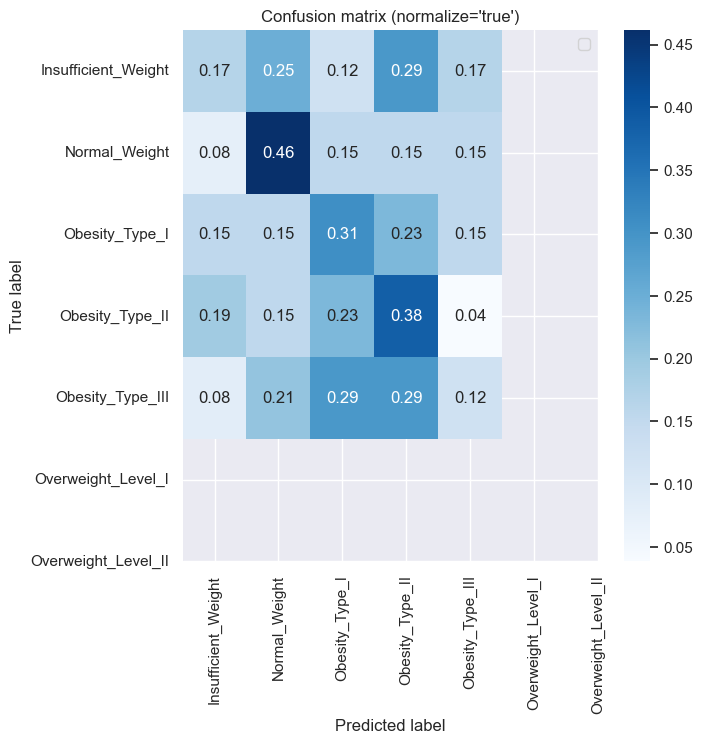

In [23]:
fig

In [24]:
y_pred

array([1, 3, 4, 3, 3, 1, 1, 3, 4, 0, 1, 1, 1, 4, 3, 3, 3, 2, 1, 2, 3, 1,
       4, 2, 1, 3, 2, 3, 3, 1, 4, 2, 0, 2, 1, 3, 3, 2, 3, 0, 1, 4, 2, 1,
       3, 2, 2, 3, 3, 2, 0, 2, 3, 3, 0, 2, 0, 2, 1, 3, 0, 0, 0, 3, 3, 2,
       2, 1, 0, 3, 1, 0, 1, 3, 2, 0, 3, 1, 4, 2, 1, 3, 1, 4, 4, 3, 2, 2,
       3, 2, 1, 1, 1, 3, 0, 0, 4, 4, 4, 2])

In [25]:
y_true

array([0, 0, 1, 0, 4, 0, 3, 4, 1, 0, 0, 1, 4, 4, 4, 3, 0, 4, 3, 1, 4, 4,
       4, 0, 1, 3, 4, 3, 1, 3, 0, 3, 0, 3, 1, 3, 3, 3, 0, 3, 3, 2, 2, 0,
       3, 3, 2, 4, 3, 0, 3, 2, 0, 0, 0, 4, 2, 4, 1, 3, 1, 4, 3, 3, 2, 2,
       3, 2, 3, 4, 4, 2, 1, 2, 3, 0, 2, 2, 0, 1, 1, 0, 4, 2, 0, 1, 4, 4,
       4, 4, 0, 0, 4, 3, 4, 3, 0, 3, 4, 0])

In [26]:
# raise ValueError("STOP")
run.finish()

Eval accuracy,▇▂▅▁▆█▄▄▅▃▇▄▇▅▆▆▅▅▅▄▇█▇▅▅▅▃▅▅▆▄▁█▄▆▇▃▆▅▆
Eval f1,█▆▄▆▄█▇█▆▇▅▇▅▆▆▁▇▇▆▇▆▅▆▅▅▇▅▅█▃▆▆▆▇▆▆█▆▁▅
Train loss,▆█▆▅▇▅▇▅▆▄▄▇▅▃▄▂▅▄▄▃▃▂▅▁▂▃▃▃▁▂▁▃▂▂▂▂▂▁▂▂
Eval accuracy,0.86802
Eval f1,0.86773
Train loss,0.34228
